# Problem 1: Random Walk Monte Carlo

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Write your own Random Walk MCMC algorithm from scratch. Don't worry if it is slow or inefficient - this exercise is about intuition building, not results. Use your sampler to fit a line to the data and generate samples from the posterior. For a first pass, run the sampler for a fixed number of steps, $N$. Then, modify the sampler to automatically stop running when a target number of effective samples $N_{\rm eff}$ has been reached.

# Problem 2: Fitting a Line

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

a) Fit the data using an ensemble sampler of your choice (recommendation: `emcee`)

b) Fit the data using a Hamiltonian Monte Carlo Sampler of your choice (recommendation: `PyMC` or `NumPyro`)

c) Fit the data using a nested sampler of your choice (recommendation: `dynesty`, `UltraNest`)

For all three cases, explicity write down the likelihood function; the `emcee` documentation has a clear explanation of how to do this. For Nested Sampling, you will also need to write a prior transform function; the `dynesty` documentation has a clear explanation of how to do this. Play around with using different priors (e.g. Gaussian, Uniform, Log-Uniform) to get a feel for the syntax of the different packages.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

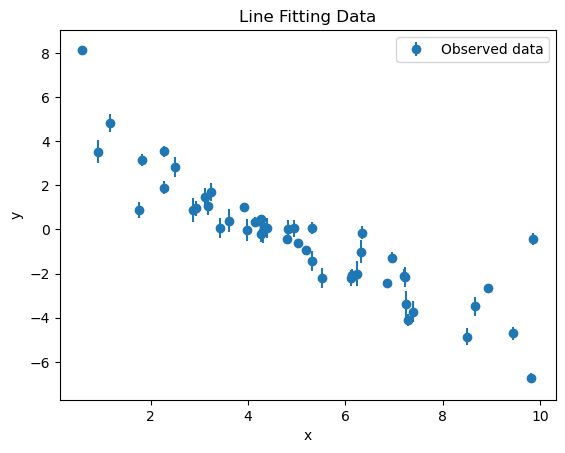

In [2]:
data = pd.read_csv('line_fitting.csv')
x_obs = data['x'].values
y_obs = data['y'].values
y_obs_unc = data['y_err'].values if 'y_err' in data.columns else np.ones_like(y_obs)

plt.errorbar(x_obs, y_obs, yerr=y_obs_unc, fmt='o', label='Observed data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Fitting Data')
plt.legend()
plt.show()

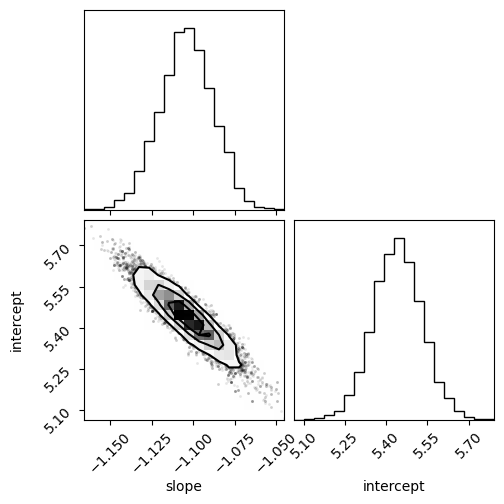

In [11]:
import emcee

def model(theta, x):
    m, b = theta
    return m * x + b

def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model_y = m * x + b
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2)


ndim = 2
nwalkers = 30
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x_obs, y_obs, y_obs_unc))

sampler.run_mcmc(p0, 1000, progress=True)

samples = sampler.get_chain(discard=500, flat=True)

import corner
fig = corner.corner(samples, labels=["slope", "intercept"])
plt.show()

In [2]:
import pymc as pm
import arviz as az

ModuleNotFoundError: No module named 'pymc'

# Problem 3: Astrophysics

Select an astrophysical dataset of your choosing. Fit the data using (a) an ensemble sampler, (b) HMC, and (c) Nested Sampling. Verify that the three methods produce equivalent results.